# Supervised Image Classification


- **Special requirements:** A Google account, access to Google Earth Engine.

- **Prerequisites:** You should have completed the "Week 3 - Prac 1", the "Week 3 - Prac 2" notebooks.


## Description
Supervised classification is one of the most popular ways to derive thematic maps in remote senisng for applications ranging from generating Land Use/Land Cover maps to change detection. 
In this session, you will learn how to colelct training samples, use machine learning techniques to allocate the whole image to one of the defined categories, perform accuracy assessments, and run some statistics for the resulting classified map. Also, you will learn how to improve the results of classification using post-classification methods.

## Aims of the practical session
* Load images for a region of interest
* Collect training samples
* Split samples into training/validation data
* Correspond training data with the data
* Use classifier
* Calculate spectral indices
* Improve classification results
* Accuracy assessement for training/validation data
* Calculating area by class

## Getting started

### Load packages

Import GEE packages that are needed for the analysis.

In [ ]:
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt

### Connect to Google Earth Engine (GEE)

Connect to the GEE to have access computing tools and GEE datasets.
You may be required to input your Google account for authorization.

In [ ]:
# Using basemap in geemap
Map = geemap.Map()

### Adding Region of Interest (ROI)

Create ROI that we want to work on it and then add and display it on the GEE map.
We can create ROI through manually drawing option in GEE or import the downloaded shapefile from your computer path. 

In [ ]:
# Draw polygon for the ROI and add layer on the GEE map.
geometry = ee.Geometry.Polygon([[
    [149.08169361455955, -35.32478551096885],
    [149.1481265674404, -35.325065623240356],
    [149.14829822881737, -35.27911424131675],
    [149.08289524419823, -35.27855369756653]
]])

Map.add_basemap('Esri.WorldImagery')
Map.addLayer(geometry, {'alpha': 0.01}, 'Canberra ROI')
Map.addLayerControl()
Map.centerObject(geometry);

## Training data

Training data (or a training dataset) constitutes the backbone of numerical classifications as is used to characterize the variability of categories within the study area. 
The quality of the training data has a greater impact on the classification than the algorithm used. Large and accurate training data sets are preferable: increasing the training sample size results in increased classification accuracy ([Maxell et al 2018](https://www.tandfonline.com/doi/full/10.1080/01431161.2018.1433343)). A review of training data methods in the context of Earth Observation is available [here](https://www.mdpi.com/2072-4292/12/6/1034)

When creating training labels, be sure to capture the spectral variability of the class, and to use imagery from the time period you want to classify (rather than relying on basemap composites). Another common problem with training data is class imbalance. This can occur when one of your classes is relatively rare and therefore the rare class will comprise a smaller proportion of the training set. When imbalanced data is used, it is common that the final classification will under-predict less abundant classes relative to their true proportion.

There are many platforms to use for gathering training labels, the best one to use depends on your application.  We can also produce our training data through Geemap Toolbar-Collecting training samples (Figure below) and then import them from your system. For more details how to collect training samples, please check this link https://www.youtube.com/watch?v=VWh5PxXPZw0.

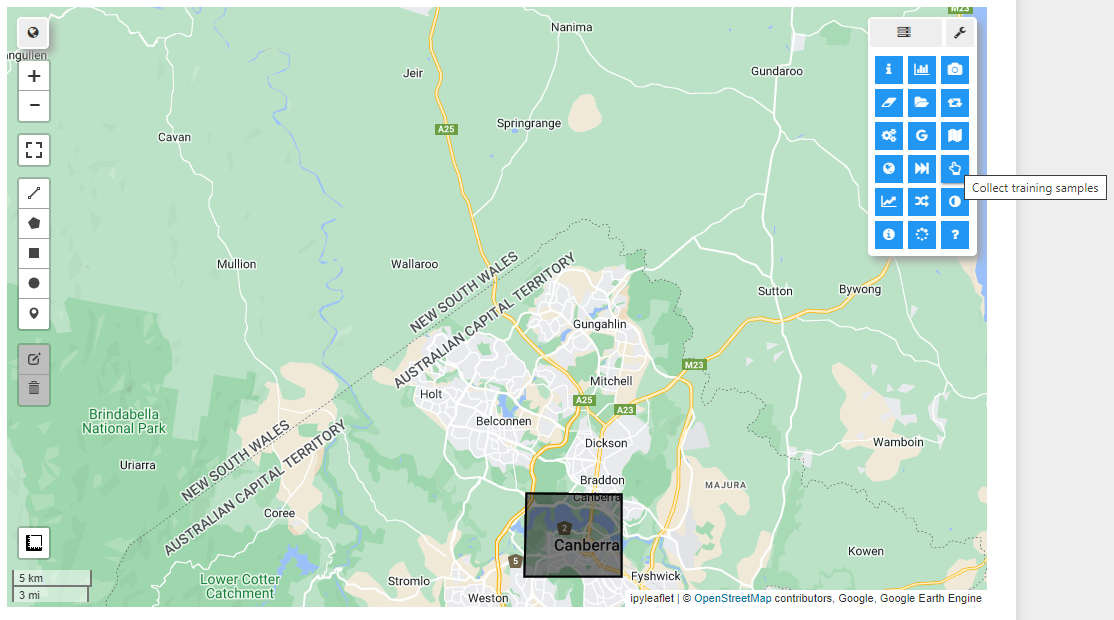


<div class="alert alert-block alert-danger"> 

## Exercise
**Try collecting training samples**. In the interactive map below, attempt to collect a few training samples for one or two class labels. Discuss with each other and your demonstrators the challenges you faced. What kinds of satellite images, band ratios, band indices, or ancillary datasets might help with collecting training samples? Do these differ between the classes? **This exercise is not marked**
        
<div>


In [ ]:
Map

We can extract the training samples from the map and save them for later using the code below:

In [ ]:
## Get information on the collecting training samples. 
Map.user_rois.getInfo()

In [ ]:
## Convert the drawing samples on the GEE to geojson
geemap.ee_to_geojson(Map.user_rois,"samples.geojson")

### Loading training samples from file

We have prepared a small training data sample for use with this practical. Below we load the file (which is stored on github as a geojson) into the notebook.

In [ ]:
#### load training data from the system's path. 
training_path = "https://raw.githubusercontent.com/nicolasyounes/engn3903/main/figures/training_data.geojson"
training_data = geemap.geojson_to_ee(training_path)

#print how many classes there are in the TD
df = geemap.ee_to_geopandas(training_data)
n_classes = len(df['landcover'].unique())
print(f'There are {n_classes} landcover classes in the training dataset')

In [ ]:
#plot the training samples
Map.addLayer(training_data, {}, 'training_data')
Map.centerObject(training_data)
Map

## Training data sampling from Sentinel-2 images

In the next few code cells we will extract training data from Sentinel-2 images over the pixels specified by the training sample locations gathered in the previous step

Sentinel-2 is a wide-swath, high-resolution, multi-spectral imaging mission supporting Copernicus Land Monitoring studies, including the monitoring of vegetation, soil and water cover, as well as observation of inland waterways and coastal areas.

We will:
* Define a function for cloud masing and resabling sentinel-2 images
* Load Sentinel-2 images for the analysis
* Filter a collection by date range
* Calculate a temporal median to collapse the time dimension
* Clip based on the geometry

In [ ]:
def maskS2clouds(image):
    qa = image.select('QA60')
    # Bits 10 and 11 are clouds and cirrus, respectively.
    cloudBitMask = 1 << 10
    cirrusBitMask = 1 << 11
    # Both flags should be set to zero, indicating clear conditions.
    mask = qa.bitwiseAnd(cloudBitMask).eq(0) \
        .And(qa.bitwiseAnd(cirrusBitMask).eq(0))
    
    return image.updateMask(mask).divide(10000) #re-scale 


In [ ]:
S2 = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(geometry)
    .filterDate('2020-09-01','2020-09-30') ### Note: you can try different dates
    .map(maskS2clouds) #map the cloudmasking/rescaling function
    .median()
    .clip(geometry)
)

vis_params = {'min': 0, 'max': 0.4, 'bands': ['B4', 'B3', 'B2']}

# Map.centerObject(point, 8)
Map.addLayer(S2, vis_params, "Sentinel-2")
Map.addLayer(training_data, {}, 'training_data')
Map

### Sample Imagery at training points to create training datasets
Now that we have created the points and labels, we need to sample the Sentinel-2 imagery using `image.sampleRegions()`. This command will extract the reflectance in the designated bands for each of the points you have created. 

We will then:
* Select the bands for training
* Sample the input imagery to get a FeatureCollection of training data

In [ ]:
# # select bands wanted to use in the classification
bands = ['B2','B3','B4','B5','B6','B7','B8','B8A','B11','B12']

In [ ]:
# # correspond training data with landsat data
# This property of the table stores the land cover labels.
label = 'landcover'

gcp = S2.select(bands).sampleRegions(
    **{'collection': training_data,
       'properties': [label],
        'scale': 20}
)

print(gcp.size().getInfo())

## Image Classification
The <a href="https://developers.google.com/earth-engine/guides/classification">Classifier</a> package in handles the assigment phase of a supervised classification by machine learning algorithms running in Earth Engine. Thus, in this part we will:
* Instantiate a supervised classifier
* Set its parameters if necessary
* Train the classifier using the training data
* Classify an image or feature collection
* Display the classified map

> Note: Here we used Support Vector Machine model for classification. You can also try different machine learning techniques

In [ ]:
# # classifier 
classifier = ee.Classifier.libsvm().train(**{
  'features' : gcp,
  'classProperty' : 'landcover',
  'inputProperties' : bands
})

classified = S2.select(bands).classify(classifier)

# # Display the clusters with random colors.
Map.addLayer(classified.randomVisualizer(), {}, 'classified')
Map

### Accuracy assessment
To assess the accuracy of a classifier use a Confusion Matrix (<a href="http://www.sciencedirect.com/science/article/pii/S0034425797000837">Stehman 1997</a>) to calculate overall accuracy (OA) and Kappa coefficient. 

In [ ]:
# # confusion matrix
train_accuracy = classifier.confusionMatrix()
train_accuracy.getInfo()

We can convert the `train_accuracy.getInfo()` results into a nicer looking (more readable) Pandas dataframe:

In [ ]:
df = pd.DataFrame(train_accuracy.getInfo())
df.columns.name = 'PREDICTION'
df.index.name = 'ACTUAL'
df.loc['TOTAL',:]= df.sum(axis=0)
#Total sum per row: 
df.loc[:,'TOTAL'] = df.sum(axis=1)
df

In [ ]:
# # accuracy
train_accuracy.accuracy().getInfo()

In [ ]:
# # kappa
train_accuracy.kappa().getInfo()

<div class="alert alert-block alert-danger"> 

## Exercise 1 - After applying the supervised classification on Sentinel-2 image explain the results of the confusion matrix  
* What was the overall omission error? what was the overall commission error?
* what were the classes that experienced more/less confusion and why?
* what could you do to improve the classification results? 
* Do you think is correct to train and test the machine learning model on the same data?
<div>


### Split the samples into training/test sets
The goal here is to split up the training sample into training data (70% of the total sample) and validation data (30% of the total data) (with randomization). The training set is used to train the model and test set is used to validate it. This is bets practice in the machine learning community.

In [ ]:
# This property of the table stores the land cover labels.
label = 'landcover'

# Add a random column and split the GCPs into training and validation set
gcp = training_data.randomColumn()

# This being a simpler classification, we take 30% points
# for validation. Normal recommended ratio is
# 70% training, 30% validation
trainingGcp = gcp.filter('random <= 0.7')
validationGcp = gcp.filter('random > 0.7')

Map.addLayer(validationGcp)

# # Overlay the point on the image to get training data.
composite = S2.select(bands)
training = composite.sampleRegions(
    **{
  'collection': trainingGcp,
  'properties': [label],
  'scale': 20}
)

print(training.size().getInfo())

In [ ]:
# # classifier
classifier1 = ee.Classifier.libsvm().train(**{
  'features' : training,
  'classProperty' : 'landcover',
  'inputProperties' : bands
})

classified = composite.classify(classifier1)

# # Display the clusters with random colors.
Map.addLayer(classified.randomVisualizer(), {}, 'classified-onlytraining_set')
Map

### Accuracy assessment

We can now conduct a similar accuracy assessment to the one we previously did, but this time using only the validation samples to test the accuracy (these validation samples were not used in the training of the classifier) 

In [ ]:
# # # Accuracy Assessment
test = classified.sampleRegions(
    **{
  'collection': validationGcp,
  'properties': [label],
  'scale': 20}
)
print(test.size().getInfo())

In [ ]:
# # # confusion matrix
test_accuracy = test.errorMatrix('landcover', 'classification')
test_accuracy.getInfo()

df = pd.DataFrame(test_accuracy.getInfo())
df.columns.name = 'PREDICTION'
df.index.name = 'ACTUAL'
df.loc['TOTAL',:]= df.sum(axis=0)
#Total sum per row: 
df.loc[:,'TOTAL'] = df.sum(axis=1)
df

In [ ]:
# # accuracy
test_accuracy.accuracy().getInfo()

In [ ]:
# # kappa
test_accuracy.kappa().getInfo()

<div class="alert alert-block alert-danger"> 

## Exercise 2

Compare the accuracy from your intial classification results with those after you conducted a train-test split:
* Did the accuracy change? If so, why?
* Explain briefly why its important in machine learning classification to implement train-test splits? There is a lot of material on the internet that might help you with this answer.

<div>

### Download confusion matrix
Use the following code to download the calculated confusion matrix and save it as CSV file in your system.

In [ ]:
# # # Download confusion matrix
import csv
import os

out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
testing_csv = os.path.join(out_dir, 'test_accuracy.csv')

with open(testing_csv, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerows(test_accuracy.getInfo())

### Export the classified result
Export the result directly to your computer

In [ ]:
# # # Export the result
import os

out_dir = os.path.join(os.path.expanduser('~'), 'Downloads')
out_file = os.path.join(out_dir, 'landcover.tif')

In [ ]:
geemap.ee_export_image(classified, filename=out_file, scale=20)

## Extracting information from the classified map
This code shows how to calculate area covered by each class in a classified image adn display it in a chart.

In [ ]:
######/ Calculating Area by Class

# Create a 2 band image with the area image and the classified image
# Divide the area image by 1e6 so area results are in Sq Km
areaImage = ee.Image.pixelArea().divide(1e6).addBands(classified)

In [ ]:
# Calculate Area by Class
# Using a Grouped Reducer
areas = areaImage.reduceRegion(**{
      'reducer': ee.Reducer.sum().group(**{
      'groupField': 1,
      'groupName': 'classification',
    }),
    'geometry': geometry,
    'scale': 20,
    'maxPixels': 1e9
    })

In [ ]:
classAreas = ee.List(areas.get('groups'))
print(classAreas.getInfo())

### Create a chart

In [ ]:
class_areas = pd.DataFrame(classAreas.getInfo())

In [ ]:
class_areas['sum'].plot.bar(figsize=(7,5))
classLabels = ['highveg', 'lowveg', 'urban', 'water']
plt.xticks([0,1,2,3], classLabels)
plt.xlabel('Classes')
plt.ylabel('Area Km^2')
ax.set_title('Area by class', fontsize=16);

<div class="alert alert-block alert-danger"> 

## Exercise 3 - Lets put all what you have learnt together. 

Run a classification to try to improve the results (for example you may want to use only the bands where there is less overlap between the different classes)

Then explain what you did and answer the following questions:
* Compare the confusion matrices. Has the accuracy of the model changed? why? 
* Recalculate area by class and explain the differences.
<div>

## References
This is where the references go. For example:

* Wu, Q., (2020). geemap: A Python package for interactive mapping with Google Earth Engine. The Journal of Open Source Software, 5(51), 2305. https://doi.org/10.21105/joss.02305

* "Earth Observation: Data, Processing and Applications" book. Available through Wattle, or http://www.crcsi.com.au/earth-observation-series.

## Additional information

**License:** The code in this notebook was initially created by the team at [Digital Earth Australia](https://github.com/GeoscienceAustralia/dea-notebooks), and has been modified by Abolfazl Abdollahi. The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 

**Contact:** If you need assistance, please post a question on the ENGN3903 Wattle site. 

**Last modified:** August 2022